[{'simId': '2fe448be-4d3a-4a84-affd-7d393162d640', 'name': 'local_simulator'}]


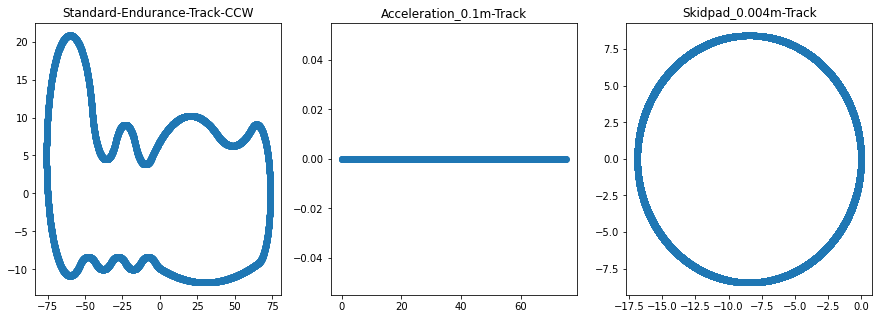

In [70]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import requests 
import json
import glob
import os

# reading in the tracks 
endur = pd.read_csv('/Users/lexy/Desktop/redbackracing-point-mass-simulator-a41704dd560f/src/tracks/Standard-Endurance-Track-CCW.csv')
accel = pd.read_csv('/Users/lexy/Desktop/redbackracing-point-mass-simulator-a41704dd560f/src/tracks/acceleration_0.1m.csv')
skidp = pd.read_csv('/Users/lexy/Desktop/redbackracing-point-mass-simulator-a41704dd560f/src/tracks/skidpad_0.004m.csv')

# plotting each track to visualise them
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))
ax1.set_title("Standard-Endurance-Track-CCW")
ax1.scatter(endur['x'],endur['y'])
ax2.set_title("Acceleration_0.1m-Track")
ax2.scatter(accel['x'],accel['y'])
ax3.set_title("Skidpad_0.004m-Track")
ax3.scatter(skidp['x'],skidp['y'])

# TO DO 
# implement scoring for each of these 3 events 

# API call - Get
r = requests.get("http://localhost:8009/api/point_mass_sim/simulators")
print(r.json())

# Retrieving the SimId 
for dict in r.json():
    dict_simId = dict['simId']
simId = dict_simId

# grid of gearRatios 
ratio_grid = np.linspace(0, 8, 100).round(2)

# API call - Post 
sessionId_array_endurance = [None] * len(ratio_grid)
sessionId_array_acceleration= [None] * len(ratio_grid)
sessionId_array_skidpad = [None] * len(ratio_grid)
tracks = ["Standard-Endurance-Track-CCW", "acceleration_0.1m", "skidpad_0.004m"]
track_index = 0 
while (track_index < 3):
    i = 0
    for gear_ratio in ratio_grid: 
        r = requests.post("http://localhost:8009/api/point_mass_sim", 
        json = {"simId": simId,
        "carId": "1",
        "title": "test",
        "description": "testing",
        "trackId": "track",
        "parameters": {
            "trackModuleList": [{
                "track": tracks[track_index]
            }],
            "generalModuleList": [{
                "driverMass": 77,
                "carMass": 200,
                "allWheelDrive": False,
                "frontMassDistribution": 0.45,
                "gravity": 9.81,
                "airDensity": 1.225
            }],
            "suspensionModuleList": [{
                "mu": 1.4,
                "tyreRadius": 0.221
            }],
            "brakeModuleList": [{
                "discRadius": 0.075,
                "muPad": 0.45,
                "pistonArea": 0.0013,
                "boreRadius": 0.007,
                "mrPedal": 1.6
            }],
            "gearModuleList": [{
                "gearChangeTime": 0.1,
                "primaryGearRatio": 2.545,
                "finalDriveRatio": gear_ratio, # CHANGING THE FINALDRIVERATIO ONLY!!!
                "driveLineEfficiency": 0.85,
                "gearRatios": [2.307, 1.8, 1.437, 1.15, 1.0]
            }],
            "powerModuleList": [{
                "powerCurve": [
                    [3000, 11370, 0.3484],
                    [4000, 17510, 0.3484],
                    [5000, 28220, 0.3078],
                    [6000, 35840, 0.2961],
                    [7000, 38970, 0.293],
                    [8000, 41970, 0.2919],
                    [9000, 42810, 0.3019],
                    [10000, 40180, 0.3049],
                    [11000, 40020, 0.321],
                    [12000, 34860, 0.321]
                ]
            }],
            "aeroModuleList": [{
                "liftCoefficient": -1.5, 
                "dragCoefficient": 0.79
            }]
        }
        }
        )

        # Retrieving the SessionId for current session 
        for dict in r.json():
            dict_sessionId = r.json()[dict]
            break

        if(track_index == 0):
            sessionId_array_endurance[i] = dict_sessionId
        elif(track_index == 1):
            sessionId_array_acceleration[i] = dict_sessionId
        else: # track_index == 2
            sessionId_array_skidpad[i] = dict_sessionId

        i = i + 1 

    track_index = track_index + 1 

In [71]:
# If you run this block instantly after the above block, it won't run properly. You need to wait for your terminal to finish compiling before running.  
idx = 0 
cols = ["GearRatio", "lapTime", "fuelConsumption", "maxBrakeForce"]
endurance_results = pd.DataFrame(columns = cols)
acceleration_results = pd.DataFrame(columns = cols)
skidpad_results = pd.DataFrame(columns = cols)

while idx < len(ratio_grid): 
    path_test_endurance = glob.glob('/Users/lexy/telemetry-system/service_data/data/1/2/'+str(sessionId_array_endurance[idx])+'/')[0]
    path_test_acceleration = glob.glob('/Users/lexy/telemetry-system/service_data/data/1/2/'+str(sessionId_array_acceleration[idx])+'/')[0]
    path_test_skidpad = glob.glob('/Users/lexy/telemetry-system/service_data/data/1/2/'+str(sessionId_array_skidpad[idx])+'/')[0]

    os.chdir(path_test_endurance)
    lis = os.listdir('.')
    if(len(lis) == 2):
        path = glob.glob('/Users/lexy/telemetry-system/service_data/data/1/2/'+str(sessionId_array_endurance[idx])+'/*-*')[0]+'/metadata.json'
        # Retrieving the Output from a single run + storing that output (lapTime, fuelConsumption, maxBrakeForce)
        f = open(str(path))
        out = json.load(f)
        endurance_results.loc[idx] = [out['data']['parameters']['finalDriveRatio'],out['data']['results']['lapTime'], out['data']['results']['fuelConsumption'], out['data']['results']['maxBrakeForce']]
        f.close()
    os.chdir('..')

    os.chdir(path_test_acceleration)
    lis = os.listdir('.')
    if(len(lis) == 2):
        path = glob.glob('/Users/lexy/telemetry-system/service_data/data/1/2/'+str(sessionId_array_acceleration[idx])+'/*-*')[0]+'/metadata.json'
        # Retrieving the Output from a single run + storing that output (lapTime, fuelConsumption, maxBrakeForce)
        f = open(str(path))
        out = json.load(f)
        acceleration_results.loc[idx] = [out['data']['parameters']['finalDriveRatio'],out['data']['results']['lapTime'], out['data']['results']['fuelConsumption'], out['data']['results']['maxBrakeForce']]
        f.close()
    os.chdir('..')

    os.chdir(path_test_skidpad)
    lis = os.listdir('.')
    if(len(lis) == 2):
        path = glob.glob('/Users/lexy/telemetry-system/service_data/data/1/2/'+str(sessionId_array_skidpad[idx])+'/*-*')[0]+'/metadata.json'
        # Retrieving the Output from a single run + storing that output (lapTime, fuelConsumption, maxBrakeForce)
        f = open(str(path))
        out = json.load(f)
        skidpad_results.loc[idx] = [out['data']['parameters']['finalDriveRatio'],out['data']['results']['lapTime'], out['data']['results']['fuelConsumption'], out['data']['results']['maxBrakeForce']]
        f.close()
    os.chdir('..')

    idx = idx + 1 

In [72]:
endurance_results

,GearRatio,lapTime,fuelConsumption,maxBrakeForce
0,0.00,23.525341,10.923068,104.644468
1,0.08,23.525341,10.923068,104.644468
2,0.16,23.525341,10.923068,104.644468
3,0.24,23.525341,10.923068,104.644468
4,0.32,23.525341,10.923068,104.644468
...,...,...,...,...
95,7.68,25.092369,2.476532,95.129999
96,7.76,25.275458,2.618625,95.129999
97,7.84,25.459244,2.451205,95.129999
98,7.92,25.643503,2.158550,95.129999


In [73]:
acceleration_results

,GearRatio,lapTime,fuelConsumption,maxBrakeForce
0,0.00,23.525341,10.923068,104.644468
1,0.08,23.525341,10.923068,104.644468
2,0.16,23.525341,10.923068,104.644468
3,0.24,23.525341,10.923068,104.644468
4,0.32,23.525341,10.923068,104.644468
...,...,...,...,...
95,7.68,25.092369,2.476532,95.129999
96,7.76,25.275458,2.618625,95.129999
97,7.84,25.459244,2.451205,95.129999
98,7.92,25.643503,2.158550,95.129999


In [74]:
skidpad_results

,GearRatio,lapTime,fuelConsumption,maxBrakeForce
0,0.00,23.525341,10.923068,104.644468
1,0.08,23.525341,10.923068,104.644468
2,0.16,23.525341,10.923068,104.644468
3,0.24,23.525341,10.923068,104.644468
4,0.32,23.525341,10.923068,104.644468
...,...,...,...,...
95,7.68,25.092369,2.476532,95.129999
96,7.76,25.275458,2.618625,95.129999
97,7.84,25.459244,2.451205,95.129999
98,7.92,25.643503,2.158550,95.129999
